In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import time


In [2]:
df = pd.read_csv("../input/train.csv")
train = df.values

train_y = train[:,0].astype('int8')
train_x = train[:,1:].astype('float64')

#train = None

print("Shape of Train images: (%d,%d)"%train_x.shape)
print("Shape Labels: (%d)" %train_y.shape)

Shape of Train images: (42000,784)
Shape Labels: (42000)


In [3]:
df = pd.read_csv("../input/test.csv")
test = df.values
print("Shape Test Images: (%d,%d)" % test.shape)

Shape Test Images: (28000,784)


In [4]:
def show_image(image, shape, label="", cmp = None):
    img = np.reshape(image, shape)
    plt.imshow(img,cmap=cmp,interpolation='none')
    plt.title(label)

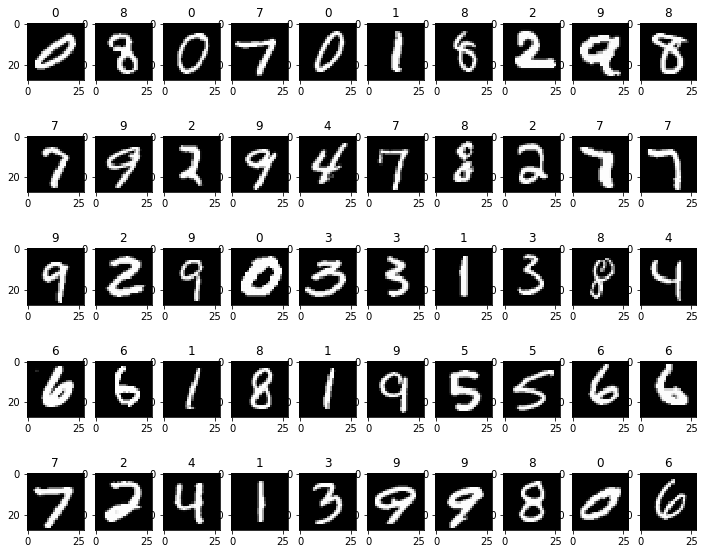

In [5]:
%matplotlib inline
plt.figure(figsize=(12,10))

y,x = 5,10
for i in range(0,(y*x)):
    plt.subplot(y,x,i+1)
    ni = np.random.randint(0,train_x.shape[0],1)[0]
    show_image(train_x[ni], (28,28), train_y[ni], cmp="gray")
plt.show()

In [7]:
def normalization(x, mu, sigma):
    x_norm = np.zeros_like(x)
    
    for n in range(len(x)):
        for j in range(len(x[n])):
            if(sigma[j]!=0):
                x_norm[n,j] = (x[n,j] - mu[j]) / sigma[j]
            else:
                x_norm[n,j] = 0
    return x_norm

In [8]:
mu = np.mean(train_x, axis=0)
sigma = np.max(train_x, axis=0) - np.min(train_x, axis=0)

In [9]:
test = normalization(test, mu, sigma)
train_x = normalization(train_x, mu, sigma)

In [10]:
train_y = pd.get_dummies(train_y).values


In [11]:
def ReLu(x, derivative = False):
    if(derivative ==  False):
        return x*( x > 0)
    else:
        return 1*(x>0)
    

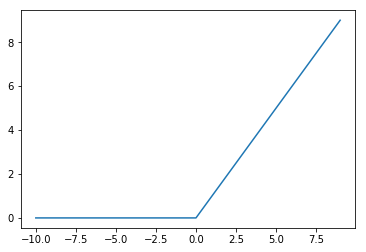

In [12]:
x = np.arange(20) - 10
relu = ReLu(x)

plt.plot(x, relu)
plt.show()

In [13]:
def Softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x), axis = 1)).T
    return sm


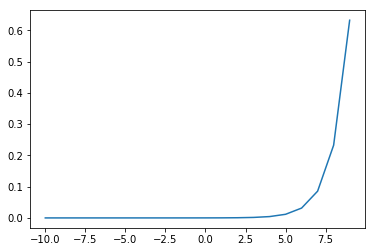

In [14]:
x = np.arange(20)-10
softmax = Softmax([x])

plt.plot(x, softmax[0])
plt.show()

In [15]:
def CreateWeights():
    ninputs = 784
    wl1 = 500
    wl2 = 300
    nclass = 10
    
    #layer1
    w1 = np.random.normal(0, ninputs**-0.5,[ninputs,wl1])
    b1 = np.random.normal(0,ninputs**-0.5,[1,wl1])
    
    #layer2
    w2 = np.random.normal(0, wl1**-0.5, [wl1,wl2])
    b2 = np.random.normal(0,wl1**-0.5, [1,wl2])
    
    #layer3
    w3 = np.random.normal(0,wl2 ** -0.5, [wl2, nclass])
    b3 = np.random.normal(0,wl2 ** -0.5, [1,nclass])
    
    return [w1,w2,w3,b1,b2,b3]
    

In [16]:
def Dropout(x, dropout_percent):
    mask = np.random.binomial([np.ones_like(x)],(1-dropout_percent))[0] / (1-dropout_percent)
    return x*mask

In [17]:
def predict(weights, x, dropout_percent=0):
    w1,w2,w3,b1,b2,b3 = weights
    first = ReLu(x@w1+b1)
    first = Dropout(first, dropout_percent)
    
    second = ReLu(first@w2 + b2)
    second = Dropout(second, dropout_percent)
    
    return [first, second, Softmax(second@w3+b3)]

In [18]:
def accuracy(output, y):
    hit = 0
    output = np.argmax(output, axis=1)
    y = np.argmax(y, axis=1)
    for y in zip(output, y):
        if(y[0] == y[1]):
            hit += 1
            
    p = (hit*100) / output.shape[0]
    return p 

In [19]:
def log2(x):
    if(x!=0):
        return np.log(x)
    else:
        return -np.inf
    
def log(y):
    return [[log2(nx) for nx in x]for x in y]

def cost(Y_predict, Y_right, weights, nabla):
    w1,w2,w3,b1,b2,b3  = weights
    weights_sum_square = np.mean(w1**2) + np.mean(w2**2) + np.mean(w3**2)
    Loss = -np.mean(Y_right*log(Y_predict) + (1-Y_right)*log(1-Y_predict)) + nabla/2 *  weights_sum_square
    return Loss

In [20]:
porcent_valid = 0.1
VALID_SIZE = round(train_x.shape[0]*porcent_valid)

index_data = np.arange(train_x.shape[0])
np.random.shuffle(index_data)

x_train = train_x[index_data[VALID_SIZE:]]
x_valid = train_x[index_data[:VALID_SIZE]]


d_train = train_y[index_data[VALID_SIZE:]]
d_valid = train_y[index_data[:VALID_SIZE]]

train_x = None
train_y = None

x_train.shape

(37800, 784)

In [21]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

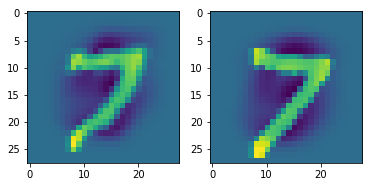

In [22]:
x_t = np.array([elastic_transform(xx.reshape(28,28),15,3).reshape(784) for xx in x_train[0:10]])
plt.subplot(1,2,1)
plt.imshow(x_t[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(x_train[0].reshape(28,28))

In [23]:
def SGD(weights, x, t, outputs, eta, gamma, nabla, cache=None):
    
    w1,w2,w3,b1,b2,b3  = weights
    
    
    if(cache==None):
            vw1 = np.zeros_like(w1)
            vw2 = np.zeros_like(w2)
            vw3 = np.zeros_like(w3)
            vb1 = np.zeros_like(b1)
            vb2 = np.zeros_like(b2)
            vb3 = np.zeros_like(b3)
    else:
        vw1,vw2,vw3,vb1,vb2,vb3 = cache
    
    first, second, y = outputs
   
    w3_delta = (t-y)
   
    w2_error = w3_delta@w3.T
    
    w2_delta = w2_error * ReLu(second,derivative=True)

    w1_error = w2_delta@w2.T
    
    w1_delta = w1_error * ReLu(first,derivative=True)
    
    eta = -eta/x.shape[0]
 
    vw3 = gamma*vw3 + eta * (second.T@w3_delta + nabla*w3)
    vb3 = gamma*vb3 + eta * w3_delta.sum(axis=0)

    vw2 = gamma*vw2 + eta * (first.T@w2_delta + nabla*w2)
    vb2 = gamma*vb2 + eta * w2_delta.sum(axis=0)

    vw1 = gamma*vw1 + eta * (x.T@w1_delta + nabla*w1)
    vb1 = gamma*vb1 + eta * w1_delta.sum(axis=0)
    
    
    w3 -= vw3
    b3 -= vb3

    w2 -= vw2
    b2 -= vb2

    w1 -= vw1
    b1 -= vb1
    
    weights = [w1,w2,w3,b1,b2,b3]
    cache = [vw1,vw2,vw3,vb1,vb2,vb3]
    
    return weights, cache
    

In [24]:
def run(weights, x_train, y_train, x_valid, y_valid, epochs = 10, nbatchs=25, alpha = 1e-3, decay = 0, momentum = 0, l2 = 0.001, dropout_percent = 0):
    
    pross = x_train.shape[0]*0.05
    
    history = [[],[]]
    
    index = np.arange(x_train.shape[0])
    cache = None
    print("Train data: %d" % (x_train.shape[0]))
    print("Validation data: %d \n" % (x_valid.shape[0]))
    mtime = 0
    
    r_weights = []
    max_accuracy_valid = 0
    
    for j in range(epochs):
        np.random.shuffle(index)
        t = 0
        iterations = round(x_train.shape[0]/nbatchs)
        prog = ""
        sacurr = 0
        sloss = 0
        sys.stdout.write("\nEpochs: %2d \ %2d \n"% (j+1,epochs))
        stime = 0
        timeIT = time.time()
        for i in range(iterations):
            timeI = time.time()
            f = i*nbatchs
            l = f+nbatchs
            
            if(l>(x_train.shape[0]-1)):
                l = x_train.shape[0]
                
            x = np.array([elastic_transform(xx.reshape(28,28),15,3).reshape(784) for xx in x_train[index[f:l]]])
            y = y_train[index[f:l]]

            outputs = predict(weights, x, dropout_percent)
            
            loss = cost(outputs[-1], y, weights, l2)
            
            accuracy_t = accuracy(outputs[-1], y)
            
            sacurr += accuracy_t
            sloss += loss
            
            accuracy_train = sacurr/(i+1)
            loss_train = sloss/(i+1)
            
            weights, cache = SGD(weights, x, y, outputs, alpha, momentum, l2, cache)
            
            t+= x.shape[0]
            
            qtd = round(t/pross)
            prog = "["
            for p in range(20):
                if(p<qtd-1):
                    prog += "="
                elif(p==qtd-1):
                    prog += ">"
                else:
                    prog += "."
            prog += "]"
            
            stime += time.time()-timeI
            mtime = stime/(i+1)
            mTimeT = mtime * (iterations-i-1)
            
            print("\r%5d/%5d %s ETA: %3d s - loss: %.4f  acc: %.4f" % (t, x_train.shape[0], prog, mTimeT, loss_train, accuracy_train))
            
            history[0].append([loss_train, accuracy_train])
        mtime = time.time()-timeIT
        alpha = alpha - (alpha*decay)
        
        outputs = predict(weights, x_valid)
        
        loss_valid = cost(outputs[-1], y_valid, weights, l2)
        accuracy_valid = accuracy(outputs[-1], y_valid)
        
        print("\r%5d/%5d %s ETA: %3d s loss: %.4f  acc: %.4f - lossValid: %.4f  accValid: %.4f " % ( t, x_train.shape[0], prog, mtime, loss_train, accuracy_train, loss_valid, accuracy_valid))
        history[1].append([loss_valid, accuracy_valid])
            
        if(accuracy_valid>=max_accuracy_valid):
            w1,w2,w3,b1,b2,b3  = weights
            r_weights = [w1.copy(),w2.copy(),w3.copy(),b1.copy(),b2.copy(),b3.copy()]
            max_accuracy_valid = accuracy_valid
        
    return r_weights, history

In [25]:
weights = CreateWeights()

alpha = 5e-2
epochs = 40
nbatchs = 100
weights, history = run(weights, 
              x_train, d_train, 
              x_valid, d_valid, 
              epochs = epochs,
              nbatchs=nbatchs, 
              alpha = alpha, 
              decay = 0.05, 
              momentum = 0.9, 
              l2 = 1e-3, 
              dropout_percent = 0.20)

Train data: 37800
Validation data: 4200 


Epochs:  1 \ 40 
11000/37800 [=====>..............] ETA:  25 s - loss: 0.1449  acc: 71.0364


22000/37800 [===========>........] ETA:  14 s - loss: 0.1097  acc: 78.5409


33100/37800 [=================>..] ETA:   4 s - loss: 0.0931  acc: 82.1027


37800/37800 [===================>] ETA:  35 s loss: 0.0885  acc: 83.0582 - lossValid: 0.0266  accValid: 95.4762 

Epochs:  2 \ 40 
 6200/37800 [==>.................] ETA:  29 s - loss: 0.0525  acc: 90.5645


17300/37800 [========>...........] ETA:  19 s - loss: 0.0510  acc: 90.6647


28400/37800 [==============>.....] ETA:   8 s - loss: 0.0481  acc: 91.1690


37800/37800 [===================>] ETA:  35 s loss: 0.0461  acc: 91.5847 - lossValid: 0.0180  accValid: 97.0476 

Epochs:  3 \ 40 
 1400/37800 [>...................] ETA:  34 s - loss: 0.0354  acc: 93.3571


12500/37800 [======>.............] ETA:  23 s - loss: 0.0380  acc: 92.9680


23700/37800 [============>.......] ETA:  13 s - loss: 0.0383  acc: 93.0506


34800/37800 [=================>..] ETA:   2 s - loss: 0.0379  acc: 93.1437


37800/37800 [===================>] ETA:  35 s loss: 0.0380  acc: 93.1693 - lossValid: 0.0145  accValid: 97.3810 

Epochs:  4 \ 40 
 8000/37800 [===>................] ETA:  28 s - loss: 0.0326  acc: 94.0875


19000/37800 [=========>..........] ETA:  17 s - loss: 0.0336  acc: 93.8895


30100/37800 [===============>....] ETA:   7 s - loss: 0.0338  acc: 93.8073


37800/37800 [===================>] ETA:  35 s loss: 0.0339  acc: 93.8016 - lossValid: 0.0135  accValid: 97.7143 

Epochs:  5 \ 40 
 3200/37800 [=>..................] ETA:  32 s - loss: 0.0308  acc: 94.4062


14300/37800 [=======>............] ETA:  22 s - loss: 0.0297  acc: 94.6573


25400/37800 [============>.......] ETA:  11 s - loss: 0.0295  acc: 94.7677


36500/37800 [==================>.] ETA:   1 s - loss: 0.0300  acc: 94.6767


37800/37800 [===================>] ETA:  35 s loss: 0.0301  acc: 94.6693 - lossValid: 0.0112  accValid: 97.8810 

Epochs:  6 \ 40 
 9500/37800 [====>...............] ETA:  26 s - loss: 0.0297  acc: 94.6632


20500/37800 [==========>.........] ETA:  16 s - loss: 0.0282  acc: 95.0098


31600/37800 [================>...] ETA:   5 s - loss: 0.0283  acc: 95.0127


37800/37800 [===================>] ETA:  35 s loss: 0.0284  acc: 95.0397 - lossValid: 0.0109  accValid: 98.1667 

Epochs:  7 \ 40 
 4700/37800 [=>..................] ETA:  31 s - loss: 0.0268  acc: 95.1702


15800/37800 [=======>............] ETA:  20 s - loss: 0.0273  acc: 95.1709


26800/37800 [=============>......] ETA:  10 s - loss: 0.0271  acc: 95.2687


37800/37800 [===================>] ETA:   0 s - loss: 0.0268  acc: 95.3175


37800/37800 [===================>] ETA:  35 s loss: 0.0268  acc: 95.3175 - lossValid: 0.0099  accValid: 98.2143 

Epochs:  8 \ 40 
10900/37800 [=====>..............] ETA:  25 s - loss: 0.0248  acc: 95.6514


22000/37800 [===========>........] ETA:  14 s - loss: 0.0246  acc: 95.7000


33100/37800 [=================>..] ETA:   4 s - loss: 0.0254  acc: 95.4985


37800/37800 [===================>] ETA:  35 s loss: 0.0257  acc: 95.4524 - lossValid: 0.0095  accValid: 98.4286 

Epochs:  9 \ 40 
 6200/37800 [==>.................] ETA:  29 s - loss: 0.0248  acc: 95.4194


17300/37800 [========>...........] ETA:  19 s - loss: 0.0247  acc: 95.5318


28400/37800 [==============>.....] ETA:   8 s - loss: 0.0237  acc: 95.7535


37800/37800 [===================>] ETA:  35 s loss: 0.0238  acc: 95.7328 - lossValid: 0.0095  accValid: 98.4286 

Epochs: 10 \ 40 
 1400/37800 [>...................] ETA:  34 s - loss: 0.0213  acc: 97.0714


12500/37800 [======>.............] ETA:  23 s - loss: 0.0237  acc: 95.8560


23600/37800 [===========>........] ETA:  13 s - loss: 0.0232  acc: 95.8390


34700/37800 [=================>..] ETA:   2 s - loss: 0.0233  acc: 95.7579


37800/37800 [===================>] ETA:  35 s loss: 0.0234  acc: 95.7672 - lossValid: 0.0093  accValid: 98.3810 

Epochs: 11 \ 40 
 7700/37800 [===>................] ETA:  28 s - loss: 0.0235  acc: 95.7792


18700/37800 [=========>..........] ETA:  17 s - loss: 0.0234  acc: 95.8503


29700/37800 [===============>....] ETA:   7 s - loss: 0.0233  acc: 95.8855


37800/37800 [===================>] ETA:  35 s loss: 0.0230  acc: 95.9048 - lossValid: 0.0088  accValid: 98.5952 

Epochs: 12 \ 40 
 2900/37800 [=>..................] ETA:  32 s - loss: 0.0227  acc: 95.8966


14000/37800 [======>.............] ETA:  22 s - loss: 0.0220  acc: 96.1286


25100/37800 [============>.......] ETA:  11 s - loss: 0.0216  acc: 96.1554


36200/37800 [==================>.] ETA:   1 s - loss: 0.0220  acc: 96.0663


37800/37800 [===================>] ETA:  35 s loss: 0.0222  acc: 96.0423 - lossValid: 0.0089  accValid: 98.4286 

Epochs: 13 \ 40 
 9200/37800 [====>...............] ETA:  27 s - loss: 0.0211  acc: 96.0870


20300/37800 [==========>.........] ETA:  16 s - loss: 0.0214  acc: 96.1084


31400/37800 [================>...] ETA:   6 s - loss: 0.0221  acc: 96.0637


37800/37800 [===================>] ETA:  35 s loss: 0.0219  acc: 96.0899 - lossValid: 0.0085  accValid: 98.6190 

Epochs: 14 \ 40 
 4400/37800 [=>..................] ETA:  31 s - loss: 0.0212  acc: 96.1818


15400/37800 [=======>............] ETA:  21 s - loss: 0.0206  acc: 96.4221


26400/37800 [=============>......] ETA:  10 s - loss: 0.0211  acc: 96.3939


37500/37800 [===================>] ETA:   0 s - loss: 0.0205  acc: 96.4400


37800/37800 [===================>] ETA:  35 s loss: 0.0205  acc: 96.4418 - lossValid: 0.0086  accValid: 98.5000 

Epochs: 15 \ 40 
10600/37800 [=====>..............] ETA:  25 s - loss: 0.0188  acc: 96.5849


21700/37800 [==========>.........] ETA:  15 s - loss: 0.0196  acc: 96.4516


32800/37800 [================>...] ETA:   4 s - loss: 0.0194  acc: 96.4726


37800/37800 [===================>] ETA:  35 s loss: 0.0197  acc: 96.4074 - lossValid: 0.0081  accValid: 98.5952 

Epochs: 16 \ 40 
 5900/37800 [==>.................] ETA:  30 s - loss: 0.0208  acc: 96.3729


16900/37800 [========>...........] ETA:  19 s - loss: 0.0202  acc: 96.4675


27900/37800 [==============>.....] ETA:  10 s - loss: 0.0200  acc: 96.5018


37800/37800 [===================>] ETA:  37 s loss: 0.0200  acc: 96.4524 - lossValid: 0.0079  accValid: 98.6429 

Epochs: 17 \ 40 
 1100/37800 [>...................] ETA:  35 s - loss: 0.0190  acc: 96.7273


12200/37800 [=====>..............] ETA:  24 s - loss: 0.0178  acc: 96.7705


23300/37800 [===========>........] ETA:  13 s - loss: 0.0186  acc: 96.6953


34300/37800 [=================>..] ETA:   3 s - loss: 0.0187  acc: 96.7143


37800/37800 [===================>] ETA:  35 s loss: 0.0186  acc: 96.7196 - lossValid: 0.0079  accValid: 98.6905 

Epochs: 18 \ 40 
 7400/37800 [===>................] ETA:  28 s - loss: 0.0165  acc: 97.2432


18500/37800 [=========>..........] ETA:  18 s - loss: 0.0179  acc: 96.9243


29600/37800 [===============>....] ETA:   7 s - loss: 0.0176  acc: 96.9662


37800/37800 [===================>] ETA:  35 s loss: 0.0178  acc: 96.8968 - lossValid: 0.0079  accValid: 98.6667 

Epochs: 19 \ 40 
 2600/37800 [>...................] ETA:  33 s - loss: 0.0182  acc: 96.8077


13700/37800 [======>.............] ETA:  22 s - loss: 0.0177  acc: 96.8467


24700/37800 [============>.......] ETA:  12 s - loss: 0.0173  acc: 96.9474


35800/37800 [==================>.] ETA:   1 s - loss: 0.0178  acc: 96.8520


37800/37800 [===================>] ETA:  35 s loss: 0.0178  acc: 96.8519 - lossValid: 0.0071  accValid: 98.8571 

Epochs: 20 \ 40 
 9000/37800 [====>...............] ETA:  27 s - loss: 0.0168  acc: 97.0000


20100/37800 [==========>.........] ETA:  16 s - loss: 0.0174  acc: 96.9353


31200/37800 [================>...] ETA:   6 s - loss: 0.0173  acc: 96.9327


37800/37800 [===================>] ETA:  35 s loss: 0.0177  acc: 96.8651 - lossValid: 0.0076  accValid: 98.7619 

Epochs: 21 \ 40 
 4400/37800 [=>..................] ETA:  31 s - loss: 0.0175  acc: 97.1364


15400/37800 [=======>............] ETA:  21 s - loss: 0.0165  acc: 97.0325


26500/37800 [=============>......] ETA:  10 s - loss: 0.0169  acc: 97.0453


37600/37800 [===================>] ETA:   0 s - loss: 0.0173  acc: 97.0213


37800/37800 [===================>] ETA:  35 s loss: 0.0173  acc: 97.0238 - lossValid: 0.0071  accValid: 98.8095 

Epochs: 22 \ 40 
10700/37800 [=====>..............] ETA:  25 s - loss: 0.0162  acc: 97.0187


21800/37800 [===========>........] ETA:  15 s - loss: 0.0162  acc: 97.0917


32800/37800 [================>...] ETA:   4 s - loss: 0.0164  acc: 97.0854


37800/37800 [===================>] ETA:  35 s loss: 0.0165  acc: 97.0820 - lossValid: 0.0073  accValid: 98.8810 

Epochs: 23 \ 40 
 5900/37800 [==>.................] ETA:  30 s - loss: 0.0169  acc: 96.9153


17000/37800 [========>...........] ETA:  19 s - loss: 0.0168  acc: 97.0118


28100/37800 [==============>.....] ETA:   9 s - loss: 0.0172  acc: 96.9715


37800/37800 [===================>] ETA:  35 s loss: 0.0170  acc: 97.0053 - lossValid: 0.0069  accValid: 98.9048 

Epochs: 24 \ 40 
 1100/37800 [>...................] ETA:  34 s - loss: 0.0204  acc: 96.8182


12200/37800 [=====>..............] ETA:  24 s - loss: 0.0160  acc: 97.2213


23300/37800 [===========>........] ETA:  13 s - loss: 0.0168  acc: 97.0429


34300/37800 [=================>..] ETA:   3 s - loss: 0.0171  acc: 97.0408


37800/37800 [===================>] ETA:  35 s loss: 0.0169  acc: 97.0767 - lossValid: 0.0069  accValid: 98.9286 

Epochs: 25 \ 40 
 7400/37800 [===>................] ETA:  28 s - loss: 0.0154  acc: 97.3514


18500/37800 [=========>..........] ETA:  18 s - loss: 0.0158  acc: 97.2541


29600/37800 [===============>....] ETA:   7 s - loss: 0.0157  acc: 97.2162


37800/37800 [===================>] ETA:  35 s loss: 0.0159  acc: 97.1640 - lossValid: 0.0069  accValid: 98.8571 

Epochs: 26 \ 40 
 2600/37800 [>...................] ETA:  33 s - loss: 0.0175  acc: 96.8846


13700/37800 [======>.............] ETA:  22 s - loss: 0.0163  acc: 97.1387


24800/37800 [============>.......] ETA:  12 s - loss: 0.0160  acc: 97.2177


35900/37800 [==================>.] ETA:   1 s - loss: 0.0161  acc: 97.1699


37800/37800 [===================>] ETA:  35 s loss: 0.0161  acc: 97.1852 - lossValid: 0.0069  accValid: 99.0000 

Epochs: 27 \ 40 
 8900/37800 [====>...............] ETA:  27 s - loss: 0.0145  acc: 97.4831


20000/37800 [==========>.........] ETA:  16 s - loss: 0.0160  acc: 97.2300


31000/37800 [===============>....] ETA:   6 s - loss: 0.0159  acc: 97.2484


37800/37800 [===================>] ETA:  35 s loss: 0.0159  acc: 97.2116 - lossValid: 0.0070  accValid: 98.8333 

Epochs: 28 \ 40 
 4100/37800 [=>..................] ETA:  31 s - loss: 0.0169  acc: 97.0000


15200/37800 [=======>............] ETA:  21 s - loss: 0.0160  acc: 97.2500


26300/37800 [=============>......] ETA:  10 s - loss: 0.0160  acc: 97.2433


37400/37800 [===================>] ETA:   0 s - loss: 0.0158  acc: 97.2674


37800/37800 [===================>] ETA:  35 s loss: 0.0158  acc: 97.2646 - lossValid: 0.0072  accValid: 98.7619 

Epochs: 29 \ 40 
10400/37800 [=====>..............] ETA:  25 s - loss: 0.0154  acc: 97.3077


21500/37800 [==========>.........] ETA:  15 s - loss: 0.0148  acc: 97.2884


32600/37800 [================>...] ETA:   4 s - loss: 0.0147  acc: 97.3037


37800/37800 [===================>] ETA:  35 s loss: 0.0147  acc: 97.2804 - lossValid: 0.0068  accValid: 98.9762 

Epochs: 30 \ 40 
 5600/37800 [==>.................] ETA:  30 s - loss: 0.0165  acc: 97.1786


16700/37800 [========>...........] ETA:  19 s - loss: 0.0154  acc: 97.3832


27800/37800 [==============>.....] ETA:   9 s - loss: 0.0150  acc: 97.4209


37800/37800 [===================>] ETA:  35 s loss: 0.0153  acc: 97.3571 - lossValid: 0.0067  accValid: 98.9524 

Epochs: 31 \ 40 
  800/37800 [....................] ETA:  35 s - loss: 0.0186  acc: 96.6250


11900/37800 [=====>..............] ETA:  24 s - loss: 0.0149  acc: 97.2773


23000/37800 [===========>........] ETA:  13 s - loss: 0.0151  acc: 97.2261


34100/37800 [=================>..] ETA:   3 s - loss: 0.0148  acc: 97.2874


37800/37800 [===================>] ETA:  35 s loss: 0.0148  acc: 97.3042 - lossValid: 0.0066  accValid: 99.0000 

Epochs: 32 \ 40 
 7100/37800 [===>................] ETA:  29 s - loss: 0.0142  acc: 97.4789


18200/37800 [=========>..........] ETA:  18 s - loss: 0.0140  acc: 97.4560


29300/37800 [===============>....] ETA:   8 s - loss: 0.0143  acc: 97.4642


37800/37800 [===================>] ETA:  35 s loss: 0.0148  acc: 97.3545 - lossValid: 0.0068  accValid: 98.9524 

Epochs: 33 \ 40 
 2300/37800 [>...................] ETA:  33 s - loss: 0.0160  acc: 96.9130


13300/37800 [======>.............] ETA:  23 s - loss: 0.0144  acc: 97.4586


24400/37800 [============>.......] ETA:  12 s - loss: 0.0148  acc: 97.4098


35500/37800 [==================>.] ETA:   2 s - loss: 0.0148  acc: 97.4056


37800/37800 [===================>] ETA:  35 s loss: 0.0149  acc: 97.3889 - lossValid: 0.0066  accValid: 99.0476 

Epochs: 34 \ 40 
 8600/37800 [====>...............] ETA:  27 s - loss: 0.0149  acc: 97.3256


19600/37800 [=========>..........] ETA:  17 s - loss: 0.0154  acc: 97.2704


30700/37800 [===============>....] ETA:   6 s - loss: 0.0149  acc: 97.3779


37800/37800 [===================>] ETA:  35 s loss: 0.0147  acc: 97.4127 - lossValid: 0.0065  accValid: 99.0238 

Epochs: 35 \ 40 
 3800/37800 [=>..................] ETA:  32 s - loss: 0.0132  acc: 97.7632


14900/37800 [=======>............] ETA:  21 s - loss: 0.0148  acc: 97.5503


26000/37800 [=============>......] ETA:  11 s - loss: 0.0147  acc: 97.4846


37100/37800 [===================>] ETA:   0 s - loss: 0.0147  acc: 97.4394


37800/37800 [===================>] ETA:  36 s loss: 0.0147  acc: 97.4339 - lossValid: 0.0067  accValid: 99.0476 

Epochs: 36 \ 40 
10100/37800 [====>...............] ETA:  26 s - loss: 0.0148  acc: 97.2772


21100/37800 [==========>.........] ETA:  15 s - loss: 0.0150  acc: 97.2417


32200/37800 [================>...] ETA:   5 s - loss: 0.0147  acc: 97.2484


37800/37800 [===================>] ETA:  36 s loss: 0.0145  acc: 97.2937 - lossValid: 0.0066  accValid: 99.0238 

Epochs: 37 \ 40 
 5300/37800 [==>.................] ETA:  30 s - loss: 0.0151  acc: 97.4151


16400/37800 [========>...........] ETA:  20 s - loss: 0.0145  acc: 97.4756


27400/37800 [=============>......] ETA:   9 s - loss: 0.0147  acc: 97.4307


37800/37800 [===================>] ETA:  35 s loss: 0.0147  acc: 97.4339 - lossValid: 0.0064  accValid: 99.1190 

Epochs: 38 \ 40 
  500/37800 [....................] ETA:  35 s - loss: 0.0114  acc: 98.0000


11500/37800 [=====>..............] ETA:  25 s - loss: 0.0137  acc: 97.5739


22600/37800 [===========>........] ETA:  14 s - loss: 0.0140  acc: 97.5044


33700/37800 [=================>..] ETA:   3 s - loss: 0.0145  acc: 97.4659


37800/37800 [===================>] ETA:  36 s loss: 0.0145  acc: 97.4788 - lossValid: 0.0066  accValid: 98.9524 

Epochs: 39 \ 40 
 6800/37800 [===>................] ETA:  29 s - loss: 0.0135  acc: 97.5588


17900/37800 [========>...........] ETA:  19 s - loss: 0.0144  acc: 97.4972


29000/37800 [==============>.....] ETA:   8 s - loss: 0.0140  acc: 97.5483


37800/37800 [===================>] ETA:  36 s loss: 0.0139  acc: 97.5608 - lossValid: 0.0063  accValid: 99.0476 

Epochs: 40 \ 40 
 2000/37800 [>...................] ETA:  34 s - loss: 0.0112  acc: 97.8000


13100/37800 [======>.............] ETA:  23 s - loss: 0.0140  acc: 97.5191


24200/37800 [============>.......] ETA:  12 s - loss: 0.0142  acc: 97.4793


35300/37800 [==================>.] ETA:   2 s - loss: 0.0144  acc: 97.4334


37800/37800 [===================>] ETA:  36 s loss: 0.0143  acc: 97.4418 - lossValid: 0.0062  accValid: 99.0238 


In [26]:
train_history = np.array(history[0])
t_loss = train_history[:,:1]
t_acc = train_history[:,1:2]


In [27]:
valid_history = np.array(history[1])
train_history.shape
v_loss = valid_history[:,:1]
v_acc = valid_history[:,1:2]

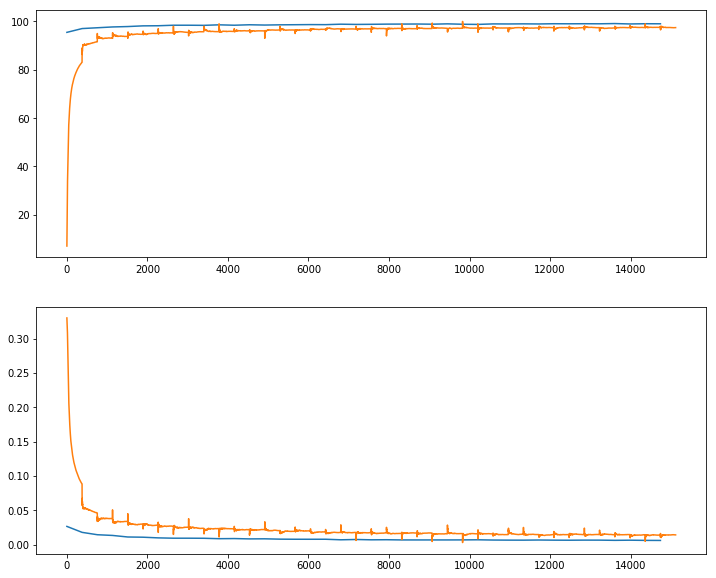

In [28]:
plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)
x = np.arange(epochs)*int(x_train.shape[0]/nbatchs)
plt.plot(x,v_acc)
plt.plot(t_acc)

plt.subplot(2, 1, 2)
plt.plot(x,v_loss)
plt.plot(t_loss)

plt.show()


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
outputs = predict(weights, x_valid)

In [31]:
p = np.argmax(outputs[-1],axis=1)
predict_dummies = pd.get_dummies(p).as_matrix().astype('int8')

cm = np.zeros((10,10)).astype(np.int64)

d_valid_int = np.argmax(d_valid, axis=1)

for i in range(predict_dummies.shape[0]):
    cm[d_valid_int[i]] += predict_dummies[i]

print(cm)


[[401   0   0   0   0   0   1   0   0   0]
 [  0 467   0   0   0   0   0   0   0   0]
 [  1   0 414   0   0   0   0   0   0   0]
 [  0   0   1 444   0   1   0   0   0   0]
 [  0   0   0   0 376   0   2   2   0   3]
 [  1   1   0   1   0 386   0   0   2   2]
 [  0   1   0   0   1   0 410   0   0   0]
 [  0   0   1   0   0   0   0 441   2   1]
 [  0   3   0   0   0   0   0   0 392   1]
 [  0   0   1   2   4   2   0   0   0 432]]


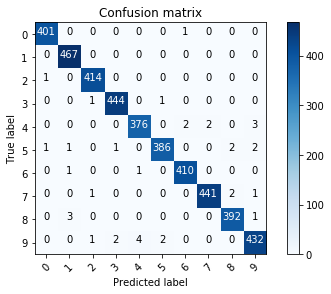

In [32]:
plot_confusion_matrix(cm, range(10))


In [33]:
s_cm = np.sum(cm,axis=0)
for i in range(10):
    p = cm[i][i]/s_cm[i]
    print("%d - %.3f %%" % (i,p))

print(" ");
print("%f %%" % accuracy(outputs[-1], d_valid))

0 - 0.995 %
1 - 0.989 %
2 - 0.993 %
3 - 0.993 %
4 - 0.987 %
5 - 0.992 %
6 - 0.993 %
7 - 0.995 %
8 - 0.990 %
9 - 0.984 %
 
99.119048 %


In [34]:
w1,w2,w3,b1,b2,b3  = weights

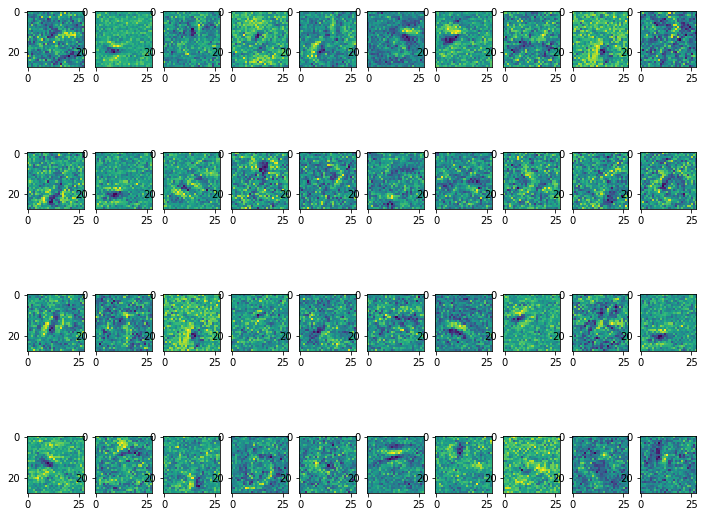

In [35]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 4,10
for i in range(0,(y*x)):
    ni = np.random.randint(0,w1.shape[1],1)[0]
    plt.subplot(y, x, i+1)
    plt.imshow(w1[:,ni].reshape((28,28)))

plt.show()

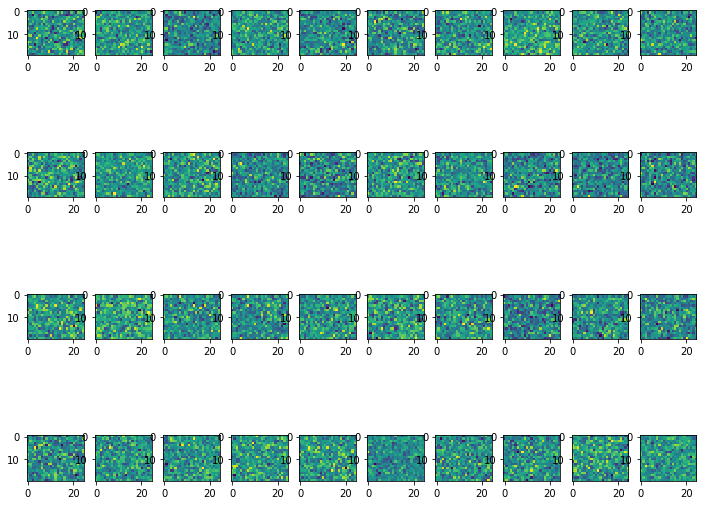

In [36]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 4,10
for i in range(0,(y*x)):
    ni = np.random.randint(0,w2.shape[1],1)[0]
    plt.subplot(y, x, i+1)
    plt.imshow(w2[:,ni].reshape((20,25)))

plt.show()

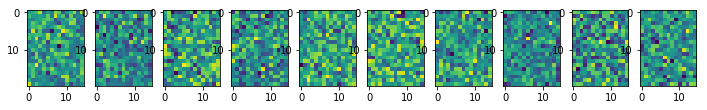

In [37]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 1,10
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    plt.imshow(w3[:,i].reshape((20,15)))

plt.show()

In [38]:
outputs = predict(weights, test)

In [39]:
d = np.argmax(outputs[-1],axis=1)

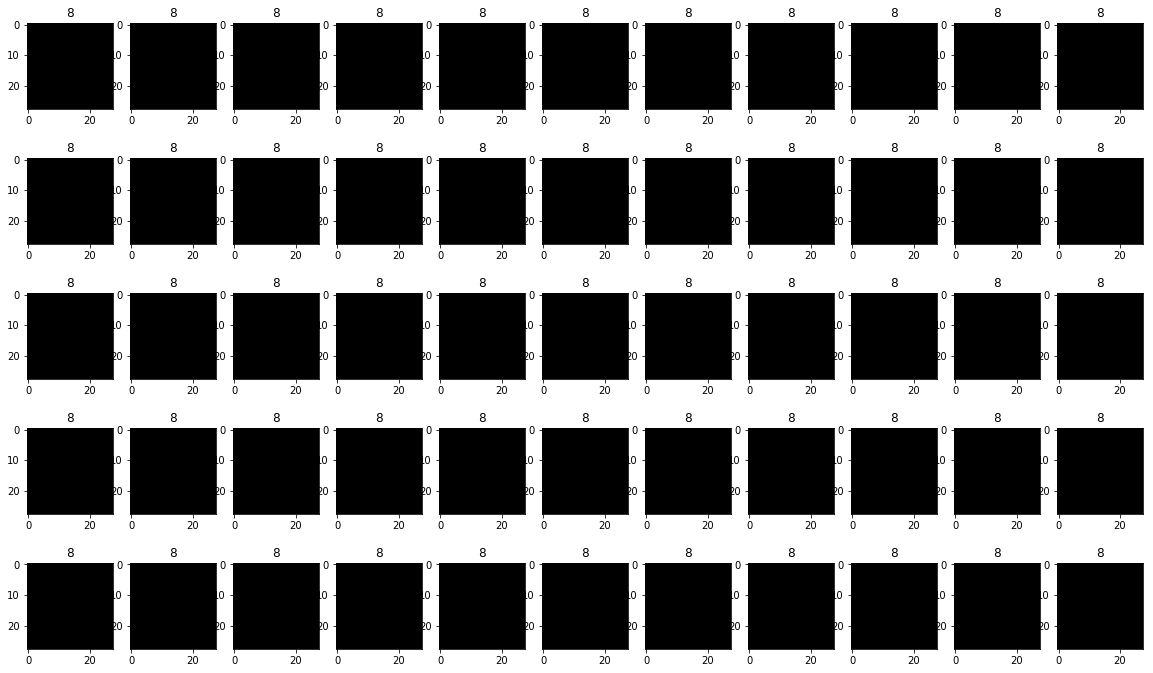

In [40]:
%matplotlib inline
plt.figure(figsize=(20,12))

y, x = 5,11
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    ni = np.random.randint(0,test.shape[0],1)[0]
    v = str(d[ni])
    show_image(test[ni],(28,28), v, cmp="gray")
plt.show()


In [41]:
pd.DataFrame({"ImageId": list(range(1,len(d)+1)), "Label": d}).to_csv('output.csv', index=False, header=True)